# Import Packages

In [1]:
import tensorflow as tf
import keras
from keras import *
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.layers import*
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os,sys
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
from keras.callbacks import History 
history = History()
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

set paths for train, test and validation and load dataset to Generator 

In [2]:
train_path = './dataset/train'
test_path = './dataset/test'
val_path = './dataset/val'

train_batches = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True).flow_from_directory(train_path, target_size=(224,224), classes =['Glaucoma_ROI','Normal_ROI'], batch_size=32)

test_batches = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True).flow_from_directory(test_path, target_size=(224,224), classes =['Glaucoma_ROI','Normal_ROI'], batch_size=32)

valid_batches = ImageDataGenerator().flow_from_directory(val_path, target_size=(224,224), classes =['Glaucoma_ROI','Normal_ROI'], batch_size=32)

Found 417 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


Function for confution matrix

In [3]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                         title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
  
  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1) [:, np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion Matrix without normalization")
  
  print(cm)
  
  thresh = cm.max() / 2.
  
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, cm[i,j],
            horizontalalignment ="center",
            color = "white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Load Training Neural Network Architecture (ZFNet)

In [4]:
model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu',input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), activation='relu'),
    keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 109, 109, 96)      14208     
_________________________________________________________________
batch_normalization (BatchNo (None, 109, 109, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 96)        0         
_________________________________________________________________
lambda (Lambda)              (None, 54, 54, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0

In [6]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model_checkpoint = ModelCheckpoint('ZFNet.hdf5', monitor='accuracy',verbose=0, save_best_only=True,mode="max")

Training Initiation

In [8]:
history = model.fit(train_batches, 
                    steps_per_epoch=10, 
                    validation_data= valid_batches, 
                    validation_steps=1,
                    epochs=50,
                    verbose=1,
                    callbacks=[model_checkpoint])

Epoch 1/50
10/10 [==============================] - 7s 412ms/step - loss: 2.6932 - accuracy: 0.5768 - val_loss: 1.8093 - val_accuracy: 0.5000
Epoch 2/50
10/10 [==============================] - 4s 394ms/step - loss: 1.5719 - accuracy: 0.7308 - val_loss: 0.8916 - val_accuracy: 0.6250
Epoch 3/50
10/10 [==============================] - 4s 389ms/step - loss: 1.3493 - accuracy: 0.7367 - val_loss: 1.3144 - val_accuracy: 0.5625
Epoch 4/50
10/10 [==============================] - 4s 396ms/step - loss: 2.2827 - accuracy: 0.7324 - val_loss: 2.7447 - val_accuracy: 0.4688
Epoch 5/50
10/10 [==============================] - 4s 382ms/step - loss: 2.4137 - accuracy: 0.6678 - val_loss: 2.4953 - val_accuracy: 0.5312
Epoch 6/50
10/10 [==============================] - 4s 371ms/step - loss: 2.5215 - accuracy: 0.6989 - val_loss: 1.8942 - val_accuracy: 0.5938
Epoch 7/50
10/10 [==============================] - 4s 387ms/step - loss: 2.0284 - accuracy: 0.7479 - val_loss: 0.8846 - val_accuracy: 0.7500
Epoch 

Training accuracy & Validation accuracy Plot

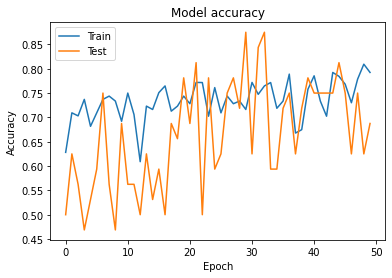

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Training loss & Validation loss Plot

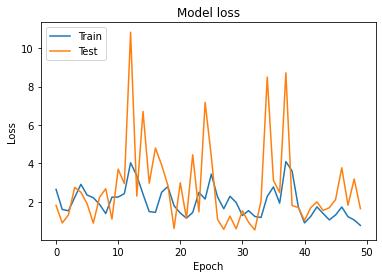

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None):
  if type(ims[0]) is np.ndarray:
    ims = np.array(ims).astype(np.uint8)
    if(ims.shape[-1] != 3):
      ims = ims.transpose ((0,2,3,1))
  f = plt.figure(figsize = figsize)
  cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
  for i in range(len(ims)):
    sp = f.add_subplot (rows, cols, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize =10)
    plt.imshow(ims[i], interpolation=None if interp else 'none')

In [12]:
test_batches_fine = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True).flow_from_directory(test_path, target_size=(224,224), classes =['Glaucoma_ROI','Normal_ROI'], batch_size=60)

Found 60 images belonging to 2 classes.


In [13]:
test_imgs, test_labels = next(test_batches_fine)

[1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1
 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0 1]
60


C:\Users\bohor\Anaconda3\envs\BN\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


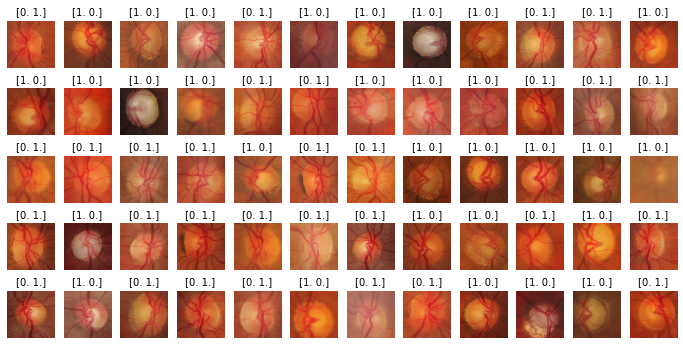

In [14]:
x_labels = test_labels.argmax(axis=1)
print(x_labels)
print(len(test_labels))
plots(test_imgs, titles=test_labels)

In [15]:
x_labels

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1], dtype=int64)

In [16]:
predictions = model.predict_generator(test_batches_fine, steps=1, verbose=0)

C:\Users\bohor\Anaconda3\envs\BN\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [17]:
y_labels = predictions.argmax(axis=1)
y_labels

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [18]:
cm = confusion_matrix(x_labels, y_labels)

In [19]:
cm_plot_labels = ['Glaucoma','Normal']

Confusion Matrix without normalization
[[30  0]
 [25  5]]


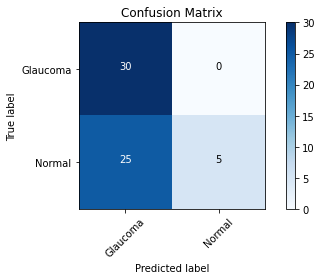

In [20]:
plot_confusion_matrix(cm, cm_plot_labels, title ='Confusion Matrix')

In [21]:
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

Sensitivity =(TP)/(TP +FN)

Specificity =(TN)/(TN+ FP)

Precision =(TP)/(TP + FP)

F1− score =(2TP)/(2TP + FP+ FN)

Accuracy =(TP + TN)/(TP + FP +FN+ TN)

In [22]:
Sensitivity =(TP)/(TP +FN)
print(Sensitivity)

0.5454545454545454


In [23]:
Specificity =(TN)/(TN+ FP)
print(Specificity)

1.0


In [24]:
Precision =(TP)/(TP + FP)
print(Precision)

1.0


In [25]:
F1score =(2*TP)/(2*TP + FP+ FN)
print(F1score)

0.7058823529411765


In [26]:
Accuracy =(TP + TN)/(TP + FP +FN+ TN)
print(Accuracy)

0.5833333333333334


In [27]:
from sklearn import metrics
pred =[]
for i in predictions:
    pred.append(i[1])
print ("AUC",metrics.roc_auc_score(x_labels, pred))

AUC 0.7955555555555555


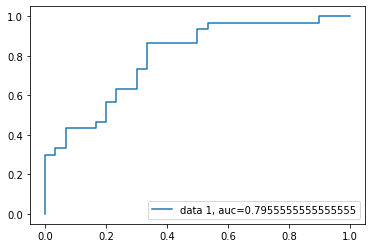

In [28]:
fpr, tpr, thresh = metrics.roc_curve(x_labels, pred)
auc = metrics.roc_auc_score(x_labels, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=0)